In [70]:
import csv
import json
import feather # pip install feather-format
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import geopandas as gpd
import ast
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
%matplotlib inline

reviews_data_path = "feather/reviews.feather"
listings_data_path = "feather/listings.feather"
calendar_data_path = "feather/calendar.feather"

# reviews_data = pd.read_feather(reviews_data_path)
# listings_data = pd.read_feather(listings_data_path)
calendar_data = pd.read_feather(calendar_data_path)

In [71]:
print("calendar data shape", calendar_data.shape)
calendar_data.head()

calendar data shape (1110686, 7)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3781,2021-07-12,f,$125.00,$125.00,32,1125
1,1644031,2021-07-12,f,$100.00,$90.00,1,1125
2,1644031,2021-07-13,f,$100.00,$90.00,1,1125
3,1644031,2021-07-14,f,$100.00,$90.00,1,1125
4,1644031,2021-07-15,f,$100.00,$100.00,1,1125


In [72]:
#remove missing
calendar_data.isnull().sum() # No null value for column "number_of_reviews"
df_calendar_data = calendar_data[calendar_data["price"].notna()]
print(df_calendar_data.isnull().sum())
print(df_calendar_data.shape)


listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64
(1110492, 7)


# separate all by their listing_id
# get average increases or decrease in price around different holidays
# each listing gets 365 days

In [73]:

df_calendar_data[df_calendar_data["listing_id"]==1644031].shape

(365, 7)

In [74]:
df_calendar_data.dtypes

listing_id         int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights     int64
maximum_nights     int64
dtype: object

In [75]:
df_calendar_data.head() 

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3781,2021-07-12,f,$125.00,$125.00,32,1125
1,1644031,2021-07-12,f,$100.00,$90.00,1,1125
2,1644031,2021-07-13,f,$100.00,$90.00,1,1125
3,1644031,2021-07-14,f,$100.00,$90.00,1,1125
4,1644031,2021-07-15,f,$100.00,$100.00,1,1125


In [76]:
# # remove dollar sign from adjusted_price 
# df_calendar_data["adjusted_price"] = df_calendar_data["adjusted_price"].str.replace("$", "")
# #remove comma from adjusted_price 
# df_calendar_data["adjusted_price"] = df_calendar_data["adjusted_price"].str.replace(",", "")
# # convert adjusted_price to float
# df_calendar_data["adjusted_price"] = df_calendar_data["adjusted_price"].astype(float)
# convert date to datetime
df_calendar_data["date"] = pd.to_datetime(df_calendar_data["date"])

# a function that removes dollar sign and comma from a string and then convert to float
def clean_price(price):
    price = price.replace("$", "")
    price = price.replace(",", "")
    price = float(price)
    return price

df_calendar_data["price"] = df_calendar_data["price"].apply(clean_price)
#apply clean_price to adjusted_price
df_calendar_data["adjusted_price"] = df_calendar_data["adjusted_price"].apply(clean_price)


/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_93514/1209371843.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calendar_data["date"] = pd.to_datetime(df_calendar_data["date"])
/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_93514/1209371843.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calendar_data["price"] = df_calendar_data["price"].apply(clean_price)
/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_93514/1209371843.py:19: SettingWithCopyWarning: 
A valu

In [78]:
df_calendar_data.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3781,2021-07-12,f,125.0,125.0,32,1125
1,1644031,2021-07-12,f,100.0,90.0,1,1125
2,1644031,2021-07-13,f,100.0,90.0,1,1125
3,1644031,2021-07-14,f,100.0,90.0,1,1125
4,1644031,2021-07-15,f,100.0,100.0,1,1125


In [79]:
# group df_calendar_data by date
df_calendar_data_grouped = df_calendar_data.groupby(by=["date"])

# df_group_by_date = df_calendar_data.groupby(level="date")
# df_group_by_date.mean()

<AxesSubplot:xlabel='date'>

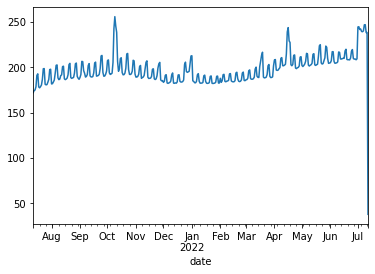

In [86]:
#  plot adjusted price
df_calendar_data_grouped.mean()["adjusted_price"].plot()

In [90]:
# add column "day_of_week" to df_calendar_data
df_calendar_data["day_of_week"] = df_calendar_data["date"].dt.dayofweek

/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_93514/1684644832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calendar_data["day_of_week"] = df_calendar_data["date"].dt.dayofweek


In [91]:
df_calendar_data

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,day_of_week
0,3781,2021-07-12,f,125.0,125.0,32,1125,0
1,1644031,2021-07-12,f,100.0,90.0,1,1125,0
2,1644031,2021-07-13,f,100.0,90.0,1,1125,1
3,1644031,2021-07-14,f,100.0,90.0,1,1125,2
4,1644031,2021-07-15,f,100.0,100.0,1,1125,3
...,...,...,...,...,...,...,...,...
1110681,50359377,2022-07-07,f,116.0,116.0,2,1125,3
1110682,50359377,2022-07-08,f,116.0,116.0,2,1125,4
1110683,50359377,2022-07-09,f,116.0,116.0,2,1125,5
1110684,50359377,2022-07-10,f,116.0,116.0,2,1125,6


<AxesSubplot:xlabel='day_of_week'>

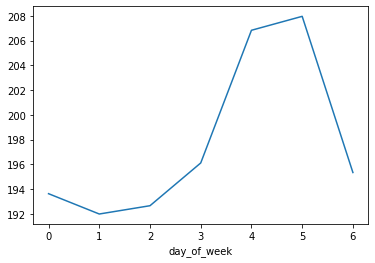

In [93]:
# group df_calendar_data by day_of_week
df_calendar_data_grouped_day_of_week = df_calendar_data.groupby(by=["day_of_week"])

# plot adjusted_price using barplot
df_calendar_data_grouped_day_of_week.mean()["adjusted_price"].plot(kind="bar")

# df_calendar_data_grouped_day_of_week.mean()["adjusted_price"].plot()

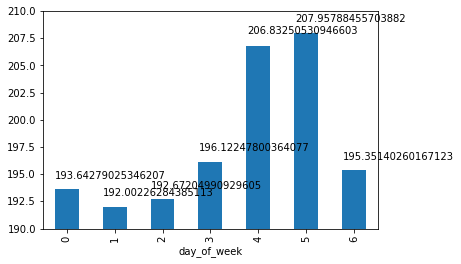

In [102]:
plot_bar = df_calendar_data_grouped_day_of_week.mean()["adjusted_price"].plot(kind="bar")
# set plot_bar x-limit to 190 to 210
plot_bar.set_ylim(190,210)

# label each bar's value
for p in plot_bar.patches:
    plot_bar.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [105]:

# add column "month_of_year" to df_calendar_data
df_calendar_data["month_of_year"] = df_calendar_data["date"].dt.month

/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_93514/2055401236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calendar_data["month_of_year"] = df_calendar_data["date"].dt.month


(175.0, 220.0)

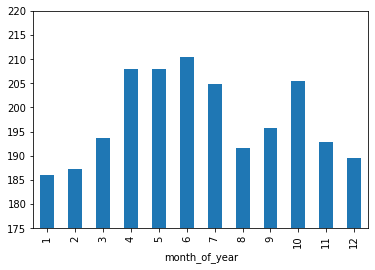

In [108]:
# group df_calendar_data by month_of_year
df_calendar_data_grouped_month_of_year = df_calendar_data.groupby(by=["month_of_year"])
# plot adjusted_price using barplot
plot_month = df_calendar_data_grouped_month_of_year.mean()["adjusted_price"].plot(kind="bar")
# set y limit from 175 to 220
plot_month.set_ylim(175,220)

(160.0, 260.0)

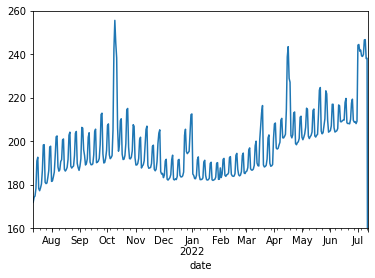

In [115]:
plot_date = df_calendar_data_grouped.mean()["adjusted_price"].plot()
# set plot_date x-limit to 160 to 210
plot_date.set_ylim(160,260)
# set x limit from january to february



(18901.0, 18962.0)

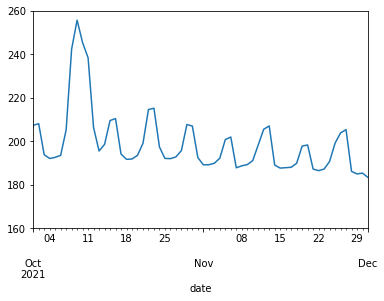

In [118]:
# datetime object for january 1 to february 1 of 2022
select_date1 = datetime.datetime(year=2021, month=10, day=1)
select_date2 = datetime.datetime(year=2021, month=12, day=1)
plot_date = df_calendar_data_grouped.mean()["adjusted_price"].plot()
# set plot_date x-limit to 160 to 210
plot_date.set_ylim(160,260)
# set x limit
plot_date.set_xlim(select_date1, select_date2)


In [120]:
# from reference_date
reference_date = datetime.datetime(2021,7,12)
# get reference_date day of week
reference_date.weekday()
# 0 means monday

0

In [125]:
day_of_week_avg = df_calendar_data_grouped_day_of_week.mean()["adjusted_price"]
# get monday price
monday_price = day_of_week_avg.loc[0]
# delete monday price from day_of_week_avg
day_of_week_diff = day_of_week_avg-monday_price
# export day_of_week_diff to csv file
day_of_week_diff.to_csv("data/processed/day_of_week_diff.csv")


In [148]:
import holidays

# get us holidays for 2022
us_holidays = holidays.US(years=[2021,2022])
# get massachusetts holidays for 2021 and 2022
massachusetts_holidays = holidays.US(state="MA", years=[2021,2022])


In [185]:
len(massachusetts_holidays)

30

In [197]:
# for each date in df_calendar_data_grouped that is a holiday, get mean adjust_price for that date
###df_calendar_data_grouped_holidays = df_calendar_data_grouped[df_calendar_data_grouped["date"] is in(us_holidays)]
df_calendar_avg= df_calendar_data_grouped.mean()["adjusted_price"]
# function that converts datetime to date
def convert_datetime_to_date(date):
    return date

# function that checks if a date is in massachusetts_holidays
def is_massachusetts_holiday(date):
    if date.date() in massachusetts_holidays:
        return True
    else:
        return False

result = []
for date in df_calendar_avg.index:
    # if is_massachusetts_holiday(convert_datetime_to_date(date)):
    #     result.append(df_calendar_data_grouped.mean()["adjusted_price"].loc[date])
    # print(date)
    result.append(is_massachusetts_holiday(date))

# print(result)
# function that counts values of a list
result_pd =pd.Series(result)
# count unique
result_pd.value_counts()

False    351
True      15
dtype: int64

In [209]:
# create dataframe with df_calendar_avg
df_calendar_avg_pd = pd.DataFrame(df_calendar_avg)
# add column "result" to df_calendar_avg_pd
df_calendar_avg_pd["result"] = result

def get_holiday_name(date):
    if date in massachusetts_holidays:
        return massachusetts_holidays[date]
    else:
        return None
# filter out result = False
df_calendar_avg_pd_result_true = df_calendar_avg_pd[df_calendar_avg_pd["result"] == True]
df_calendar_avg_pd_result_true["holiday_name"] = df_calendar_avg_pd_result_true.index
df_calendar_avg_pd_result_true["holiday_name"] = df_calendar_avg_pd_result_true["holiday_name"].apply(get_holiday_name)


/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_93514/1451583841.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calendar_avg_pd_result_true["holiday_name"] = df_calendar_avg_pd_result_true.index
/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_93514/1451583841.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calendar_avg_pd_result_true["holiday_name"] = df_calendar_avg_pd_result_true["holiday_name"].apply(get_holiday_name)


In [208]:
test =df_calendar_avg_pd_result_true['holiday_name'].iloc[0]
# massachusetts_holidays[test]
test in massachusetts_holidays

True

In [210]:
df_calendar_avg_pd_result_true

,adjusted_price,result,holiday_name
date,,,
2021-09-06,193.403682,True,Labor Day
2021-10-11,238.294214,True,Columbus Day
2021-11-11,198.160421,True,Veterans Day
2021-11-25,199.019395,True,Thanksgiving
2021-12-24,202.765286,True,Christmas Day (Observed)
2021-12-25,205.512492,True,Christmas Day
2021-12-31,212.218606,True,New Year's Day (Observed)
2022-01-01,212.535832,True,New Year's Day
2022-01-17,182.311206,True,Martin Luther King Jr. Day


In [213]:
reference_price = df_calendar_avg.iloc[0]
df_calendar_avg_pd_result_true["diff"] = df_calendar_avg_pd_result_true["adjusted_price"]-reference_price

/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_93514/3376957875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calendar_avg_pd_result_true["diff"] = df_calendar_avg_pd_result_true["adjusted_price"]-reference_price


In [214]:
df_calendar_avg_pd_result_true

,adjusted_price,result,holiday_name,diff
date,,,,
2021-09-06,193.403682,True,Labor Day,21.504635
2021-10-11,238.294214,True,Columbus Day,66.395168
2021-11-11,198.160421,True,Veterans Day,26.261374
2021-11-25,199.019395,True,Thanksgiving,27.120349
2021-12-24,202.765286,True,Christmas Day (Observed),30.866240
2021-12-25,205.512492,True,Christmas Day,33.613445
2021-12-31,212.218606,True,New Year's Day (Observed),40.319560
2022-01-01,212.535832,True,New Year's Day,40.636785
2022-01-17,182.311206,True,Martin Luther King Jr. Day,10.412160


<AxesSubplot:xlabel='holiday_name'>

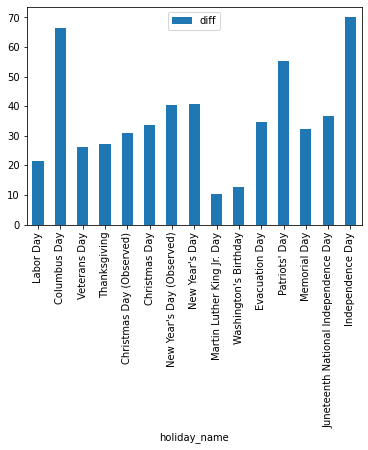

In [252]:
# plot diff vs holiday_name using barplot
df_calendar_avg_pd_result_true.plot(kind="bar", x="holiday_name", y="diff")
# df_calendar_avg_pd_result_true.plot(x="holiday_name", y="diff")

In [215]:
# export df_calendar_avg_pd_result_true to csv file
df_calendar_avg_pd_result_true.to_csv("data/processed/massachusetts_holidays.csv")

In [245]:
# function that counts days between two dates
def count_days_between_two_dates(date1, date2):
    return (date2-date1).days

# function that count minimum day between a date and massachusetts_holidays
def count_min_day_between_date_and_massachusetts_holidays(date):
    min_day = 4
    for holiday in massachusetts_holidays:
        if abs(count_days_between_two_dates(date, holiday)) <= min_day:
            return (True, massachusetts_holidays[holiday], count_days_between_two_dates(date, holiday) )
    return (False, None, count_days_between_two_dates(date, holiday))

result_tf = []
result_holiday_name = []
result_days_from_holiday = []
df_calendar_avg_pd_more_days = pd.DataFrame(df_calendar_avg)
df_calendar_avg_pd_more_days["date2"] = df_calendar_avg_pd_more_days.index
for date in df_calendar_avg_pd_more_days['date2']:
    result_tf.append(count_min_day_between_date_and_massachusetts_holidays(date.date())[0])
    result_holiday_name.append(count_min_day_between_date_and_massachusetts_holidays(date.date())[1])
    result_days_from_holiday.append(count_min_day_between_date_and_massachusetts_holidays(date.date())[2])

df_calendar_avg_pd_more_days['holiday_3_days']=result_tf
df_calendar_avg_pd_more_days['holiday']=result_holiday_name
df_calendar_avg_pd_more_days['days_from_a_holiday']=result_days_from_holiday
reference_price = df_calendar_avg.iloc[0]
df_calendar_avg_pd_more_days["diff"] = df_calendar_avg_pd_more_days["adjusted_price"]-reference_price

In [246]:
df_calendar_avg_pd_more_days['holiday_3_days'].value_counts()

False    250
True     116
Name: holiday_3_days, dtype: int64

In [247]:
df_calendar_avg_pd_more_days

,adjusted_price,date2,holiday_3_days,holiday,days_from_a_holiday,diff
date,,,,,,
2021-07-12,171.899046,2021-07-12,False,None,532,0.000000
2021-07-13,174.254438,2021-07-13,False,None,531,2.355392
2021-07-14,174.799474,2021-07-14,False,None,530,2.900428
2021-07-15,178.391847,2021-07-15,False,None,529,6.492801
2021-07-16,190.919461,2021-07-16,False,None,528,19.020415
...,...,...,...,...,...,...
2022-07-08,246.551463,2022-07-08,True,Independence Day,-4,74.652417
2022-07-09,246.727721,2022-07-09,False,None,170,74.828675
2022-07-10,238.048997,2022-07-10,False,None,169,66.149951


In [248]:
df_calendar_avg_pd_more_days
# filter holiday_3_days = True
df_calendar_avg_pd_more_days_holiday_3_days_true = df_calendar_avg_pd_more_days[df_calendar_avg_pd_more_days["holiday_3_days"] == True]


In [249]:
df_calendar_avg_pd_more_days_holiday_3_days_true

,adjusted_price,date2,holiday_3_days,holiday,days_from_a_holiday,diff
date,,,,,,
2021-09-02,191.933268,2021-09-02,True,Labor Day,4,20.034221
2021-09-03,206.349112,2021-09-03,True,Labor Day,3,34.450066
2021-09-04,206.027285,2021-09-04,True,Labor Day,2,34.128238
2021-09-05,196.111111,2021-09-05,True,Labor Day,1,24.212065
2021-09-06,193.403682,2021-09-06,True,Labor Day,0,21.504635
...,...,...,...,...,...,...
2022-07-04,241.919106,2022-07-04,True,Independence Day,0,70.020059
2022-07-05,239.241368,2022-07-05,True,Independence Day,-1,67.342322
2022-07-06,238.990135,2022-07-06,True,Independence Day,-2,67.091088


In [ ]:
df_calendar_avg_pd_more_days_holiday_3_days_true

In [250]:
# export df_calendar_avg_pd_more_days_holiday_3_days_true to csv file
df_calendar_avg_pd_more_days_holiday_3_days_true.to_csv("data/processed/massachusetts_holidays_4_days.csv")